# Real Estate Regression Model -  Predicting Price Based on House's Features

Project Group 44: Abhigyan Dabla, Ku Itoi, Luna Liu, Shuyan Liu

Word Count: 2084

## I. Introduction

Toronto is Canada’s largest city and has Canada's most popular real estate market (McNutt, 2020). The market has been growing for decades, causing a rise in house prices.

Despite the negative impact of the COVID-19 pandemic on Toronto's housing market, the demand is increasing once again (Foran, 2020). Due to the pandemic, interest and mortgage rates have decreased to the lowest rate in recent history (Foran, 2020). This creates opportunities for more people to invest or seek a more affordable price for their property. For those buyers and investors, it is significant to understand how house prices are determined in order to estimate the actual value of a house.

Therefore, we are interested in creating a regression model to predict the price of a house based on its characteristics. Specifically, we will be looking at condo apartments in Toronto. Since August 2015, condo apartments in Toronto have seen a massive 78% increase in price (Rane, 2020). Detached houses, on the other hand, have seen an increase in house price of 51% (Rane, 2020). This has led many financial analysts to believe that condo apartments are valuable investments that will continue to grow over the next few decades.

We found an open-source dataset about Toronto’s real estate market on GitHub. The data was obtained from Zoocasa, a Toronto-based real estate company which uses online search tools to allow Canadians to buy and sell their homes. The dataset includes various variables which describe the characteristics of the house and its price. We are interested in investigating Condo Apartments with the following variables from the dataset:
    
- Size of house (squared feet) 
- Mean income of district (CAD)
 
The question our project will aim to answer is **"Can we create regression models for real estate data from Toronto to accurately predict the value of a condo apartment based on the land area (in squared feet) and the mean income of the district (in CAD) of the property?"**

## II. Method and Results

**2.1 Loading Necessary Libraries**

Before we begin, we must load the necessary libraries for this study. These libraries will allow us to carry out various operations to analyze our data.

In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
library(GGally)
install.packages('plotly')
library(plotly)
library(reshape2)
install.packages("plot3D")
library("plot3D")
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3    

**2.2 Reading Data into R**

Now, we can read our file into R. As the file consists of comma separated values, we will use the `read_csv` function.

In [2]:
data <- read_csv("https://raw.githubusercontent.com/slavaspirin/Toronto-housing-price-prediction/master/houses_edited.csv")
# not going to display the head of the dataset since it is very large and redundant before cleaning and wrangling

Parsed with column specification:
cols(
  .default = col_double(),
  title = col_character(),
  bedrooms = col_character(),
  description = col_character(),
  mls = col_character(),
  type = col_character(),
  full_link = col_character(),
  full_address = col_character(),
  city_district = col_character()
)

See spec(...) for full column specifications.



**2.3 Cleaning and Wrangling Data**

We are going to clean and wrangle the dataset to get rid of any redundant information.

In [3]:
toronto_real_estate_data <- data %>%
            # Step 1: Filtering for condo apartments.
            filter(type == "Condo Apt") %>%
            # Step 2: Selecting relevant columns.
            select(price = final_price, # renaming final_price to price
                   sqft,
                   mean_district_income)
head(toronto_real_estate_data)

price,sqft,mean_district_income
<dbl>,<dbl>,<dbl>
855000,850,56526
550000,550,57039
665000,650,70623
368000,250,44101
269900,650,29573
357500,250,52787


**2.4. Exploring Dataset**

Next, we should explore our dataset to see if anything is concerning.

NA values are missing values which influence our model's performance and predictive capacity. They could potentially affect our statistical parameters/inferences. Hence, conclusions can be misleading.

By composing the `colSums()` and `is.na()` functions, we can check for NA values. 

In [4]:
colSums(is.na(toronto_real_estate_data))

price                 sqft mean_district_income 
                   0                    0                    0

As seen above, there are no NA values in the dataset, so we will not face problems with missing values.

Additionally, before we split our data into training and testing sets, we should examine how many observations there are in our dataset.

In [5]:
number_obs <- toronto_real_estate_data %>%
        summarize(n = n()) %>% # Counts number of rows
        select(n) %>%          # Selects "n" column
        pull()                 # Pulls value - count of observations
number_obs

[1] 7572

Since we have over 7500 observations, we will use 75% of the data for training and 25% for testing.

This ratio split is appropriate because we want a large training dataset to build an accurate model and a large enough testing dataset to get a reasonable understanding of the model's accuracy.

**2.4 Splitting into Training and Testing Data**

Using `initial_split()`, we can split our data into training and testing sets.

In [6]:
set.seed(2020) # Setting Seed

# Step 1: Creating a split. We provide our dataset as the first parameter, identify the ratio to be 75:25 between training
# and testing datasets, and acknowledge our strata variable as price.
toronto_real_estate_data_split <- initial_split(toronto_real_estate_data, prop = 0.75, strata = price)

#Step 2: Making the training and testing datasets.
toronto_real_estate_data_training <- training(toronto_real_estate_data_split) # Training Set
toronto_real_estate_data_testing <- testing(toronto_real_estate_data_split)   # Testing Set

Next, we should visualize the relationship between the variables of interest, `sqft`, `mean_district_income`, and `price`. We can do so by applying the `ggpairs()` function to our training data.

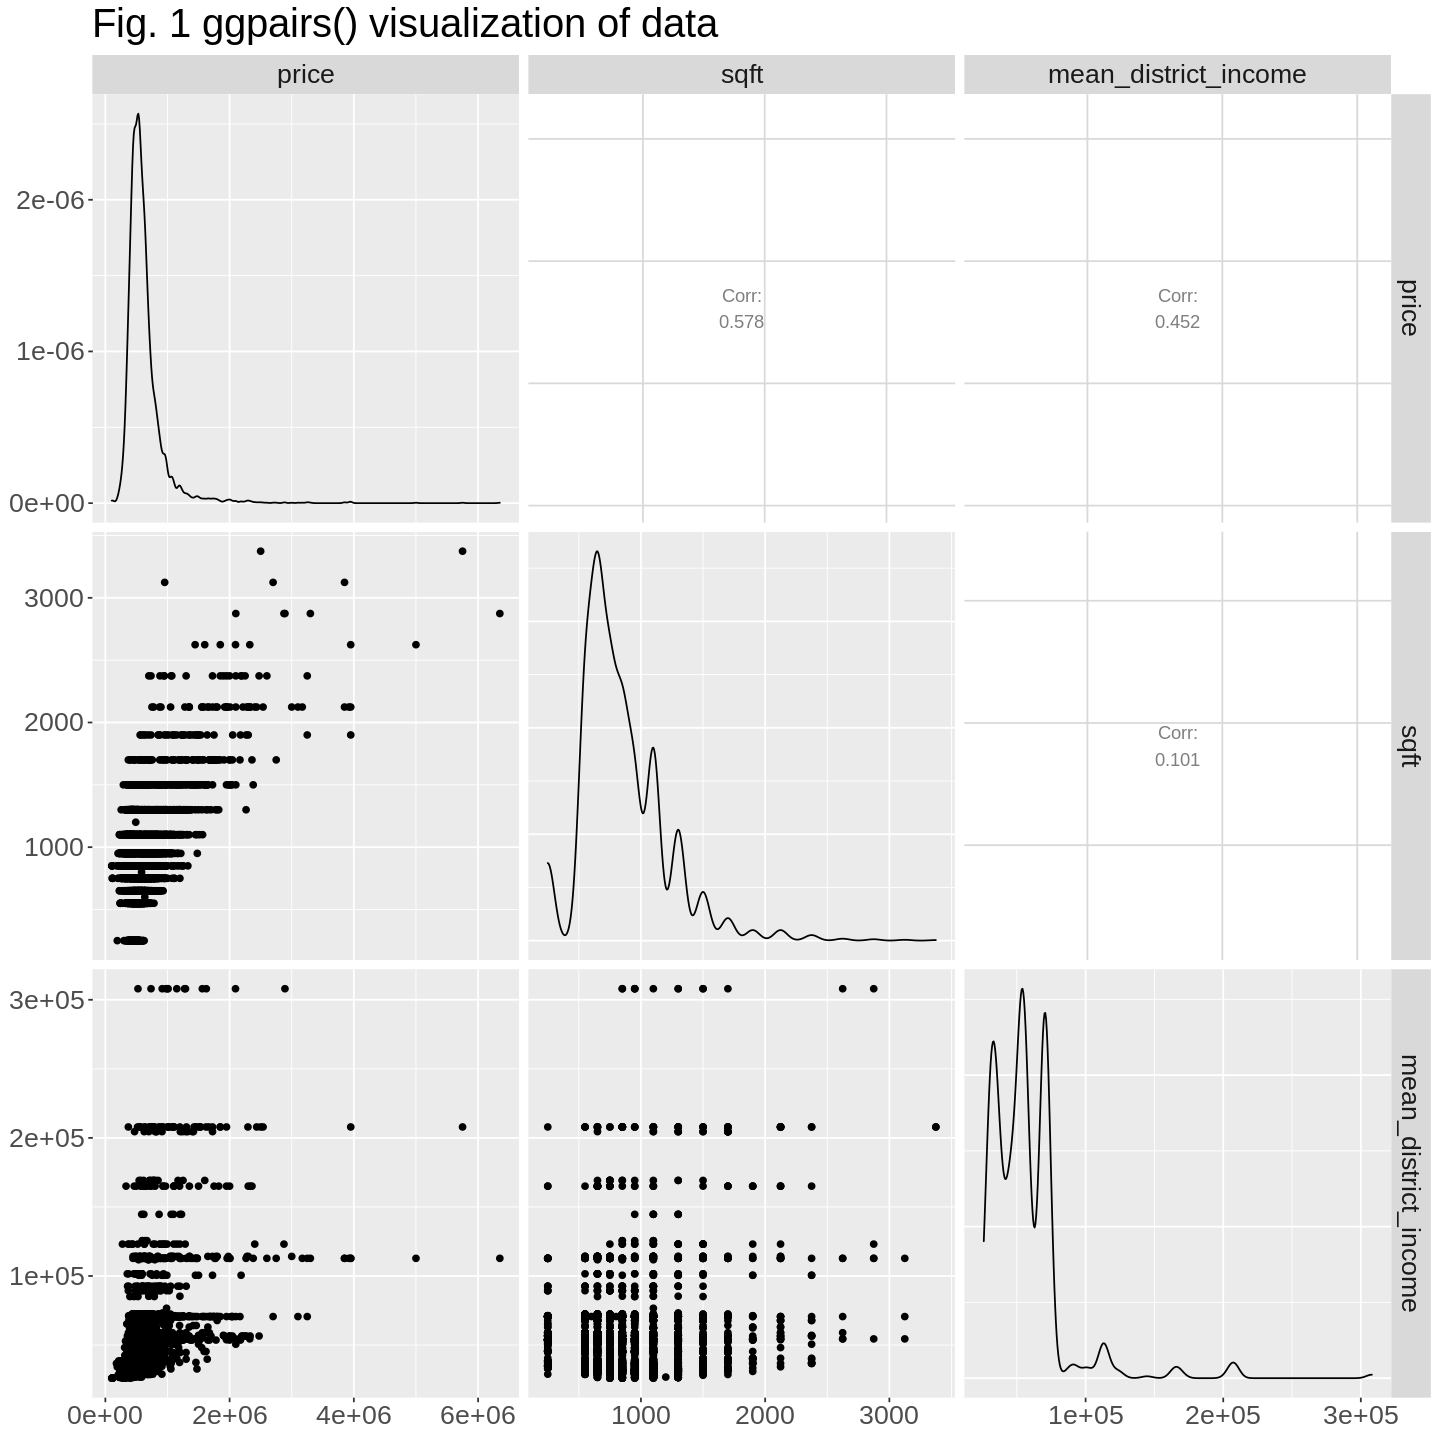

In [7]:
options(repr.plot.width = 12, repr.plot.height = 12) # Controls Plot Size

summarize_train <- toronto_real_estate_data_training %>%
            ggpairs() +
            ggtitle("Fig. 1 ggpairs() visualization of data") +
            theme(text = element_text(size = 20))
summarize_train

In Figure 1, we can see a moderately strong positive correlation between both of the predictors and `price` because as the predictors increase in magnitude, so does price.

To reiterate, as the size of an apartment increases, the price of it increases too. As the mean district income increases, the apartment's price increases as well.

As linear regression models are time and cost efficient, highly interpretable, and easily applicable, we can create one to predict prices of condo apartments for the dataset.

We can use `sqft` and `mean_district_income` as predictors to predict the price of a condo apartment.

In [8]:
# Making the Linear Regression Model
lm_spec <- linear_reg() %>%
            set_engine("lm") %>%
            set_mode("regression")

# Designing the Linear Regression Recipe
lm_recipe <- recipe(price ~ sqft + mean_district_income,
                    data = toronto_real_estate_data_training)

# Adding the Recipe and the Model to the Workflow
lm_fit <- workflow() %>%
            add_recipe(lm_recipe) %>%
            add_model(lm_spec) %>%
            fit(data = toronto_real_estate_data_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
         (Intercept)                  sqft  mean_district_income  
           -50975.21                497.32                  4.47  


From the output of our linear regression model, we can derive a formula for house price.

$Price = -50975.21\: +\: 497.32 * Square\: Feet\: +\: 4.47 * Mean\: District\: Income$

Now that we have built our model, we can visualize the best fit lines our model uses between the predictors and price.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



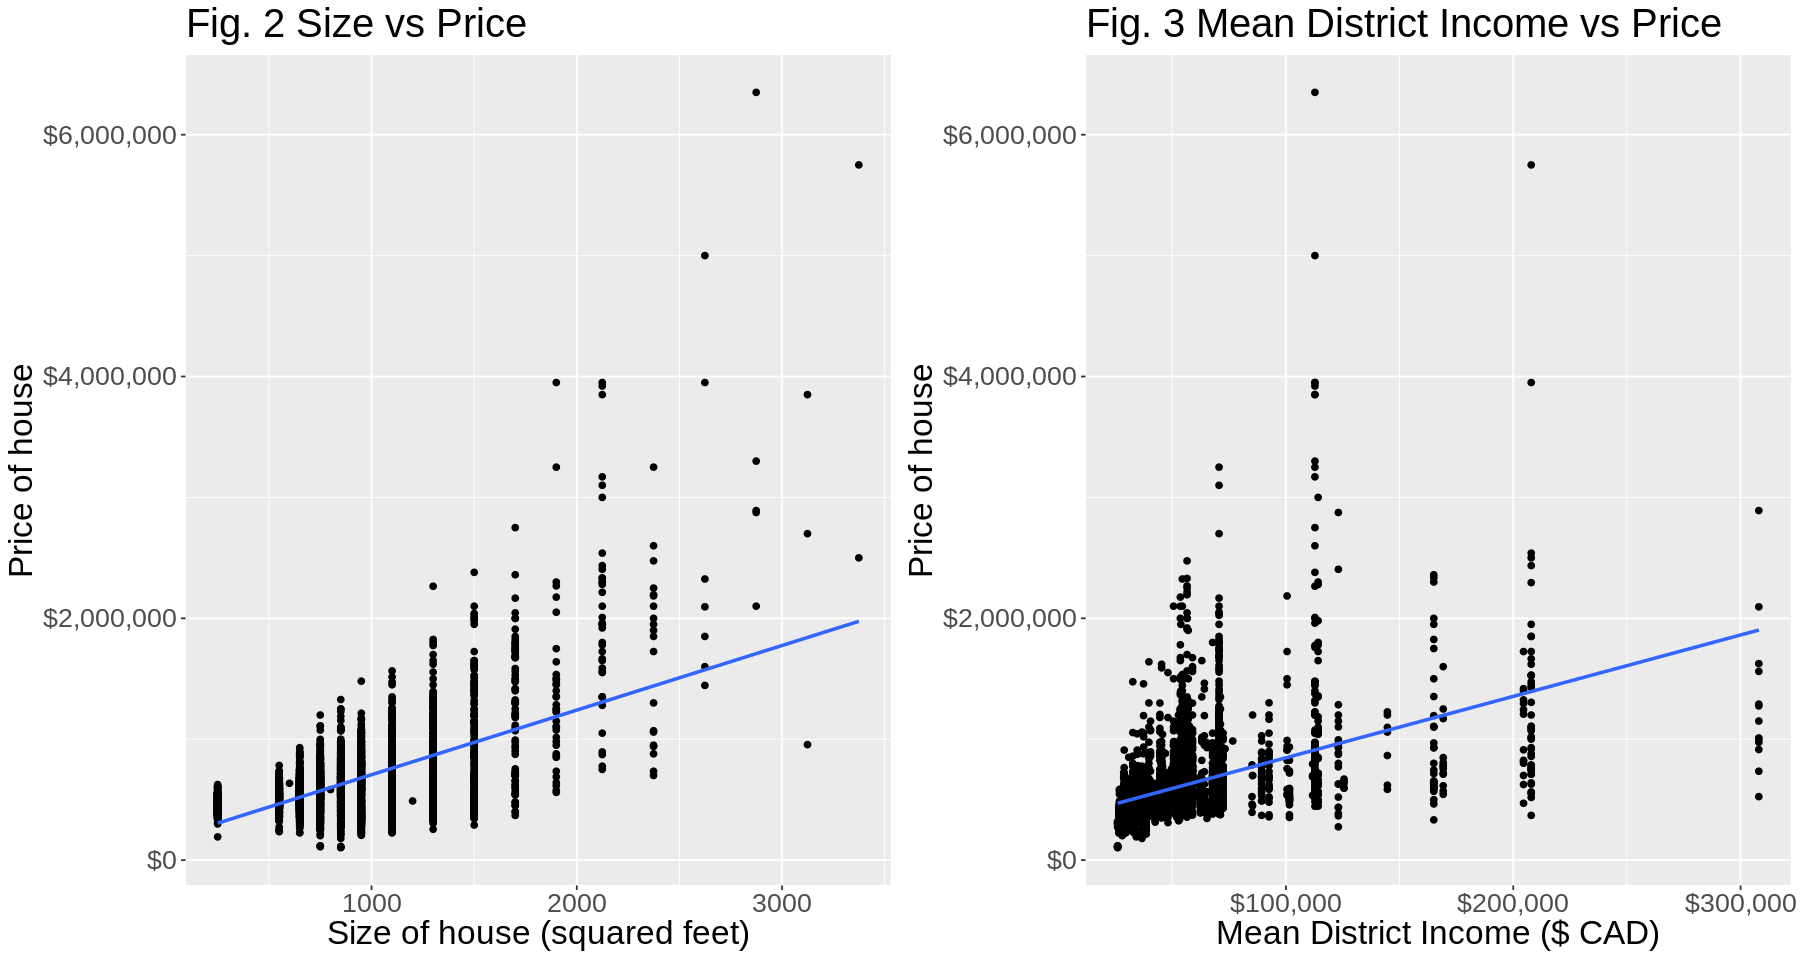

In [9]:
options(repr.plot.width = 15, repr.plot.height = 8) # Controls Plot Size

# Size of House vs Price Plot
size_vs_price <- ggplot(toronto_real_estate_data_training, aes(x = sqft, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) + # Linear Trend Line
    labs(x = "Size of house (squared feet)", y = "Price of house") +
    scale_y_continuous(labels = dollar_format()) +
    theme(text = element_text(size = 20)) +
    ggtitle("Fig. 2 Size vs Price")

# Median Destrict Income vs Price Plot
income_vs_price <- ggplot(toronto_real_estate_data_training, aes(x = mean_district_income, y = price)) +
    geom_point() +
    geom_smooth(method= "lm" , se = FALSE) + # Linear Trend Line
    labs(x = "Mean District Income ($ CAD)", y = "Price of house") +
    scale_y_continuous(labels = dollar_format()) +
    scale_x_continuous(labels = dollar_format()) +
    theme(text = element_text(size = 20)) +
    ggtitle("Fig. 3 Mean District Income vs Price")

# Arranging plots designed above side by side
grid.arrange(size_vs_price, income_vs_price, ncol = 2)

From the plots above, we can see the linear trend the regression model has identified between `sqft` and `price`, and `mean_district_income` and `price`. As we mentioned earlier, the correlation between the two predictors and price is positive. 

However, we need to see how well our regression model can predict price. To investigate this, we can calculate the Root Mean Squared Error (RMSE) of our model.

In [10]:
lm_train_results <- lm_fit %>%
                predict(toronto_real_estate_data_training) %>%   # Predicts price for all training data
                bind_cols(toronto_real_estate_data_training) %>% # Binds the columns of the training dataset to predictions
                metrics(truth = price, estimate = .pred) %>%     # Calculates the metrics of the model's predictions
                filter(.metric == 'rmse')                        # Selects the RMSE metric
lm_train_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,233562.5


Our RMSE for our training data is 233,562.5.

We must now calculate the Root Mean Squared Prediction Error (RMSPE) with our testing data.

In [11]:
lm_test_results <- lm_fit %>%
                predict(toronto_real_estate_data_testing) %>%   # Predicts price for all testing data
                bind_cols(toronto_real_estate_data_testing) %>% # Binds the columns of the testing dataset to predictions
                metrics(truth = price, estimate = .pred) %>%    # Calculates the metrics of the model's predictions
                filter(.metric == 'rmse')                       # Selects the RMSE metric
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,224910.5


The Root Mean Squared Prediction Error (RMSPE) is 224,910.5. Since our RMSE and RMSPE are nearly identical, our model is not heavily biased by the training data and its performance is consistent with the data it has and has not yet seen.

Although the RMSE and RMSPE are similar, this does not mean that our predictions are very accurate.

We want to see how our model will perform in real life, so we can look for the average price of an apartment in our dataset.

In [12]:
average_condo_apt_price <- toronto_real_estate_data_training %>%
                    select(price) %>%
                    summarize(mean = mean(price)) %>%
                    pull()
average_condo_apt_price

[1] 627797.2

We find that the average price of a house is $\$630,000$.

Now, for example, if an apartment costs $\$700,000$, we can compare this price to a range in which our model can give a prediction. Since the RMSE is larger than 200,000, our model can predict the price of this apartment between around $\$500,000$ and $\$900,000$. This is a very large range for a prediction and most likely, the prediction would not be very accurate.

Similarly, our model's predictions of the prices of many observations in our data could belong anywhere in a large range. This is due to the relatively large RMSE that our model has when considering the price of the apartments in the dataset. Thus, we can conclude that our model is not very precise.

To assess how the error varies with the actual price in our predictions, we can see how our linear regression model fits our training data with a 3D plot.

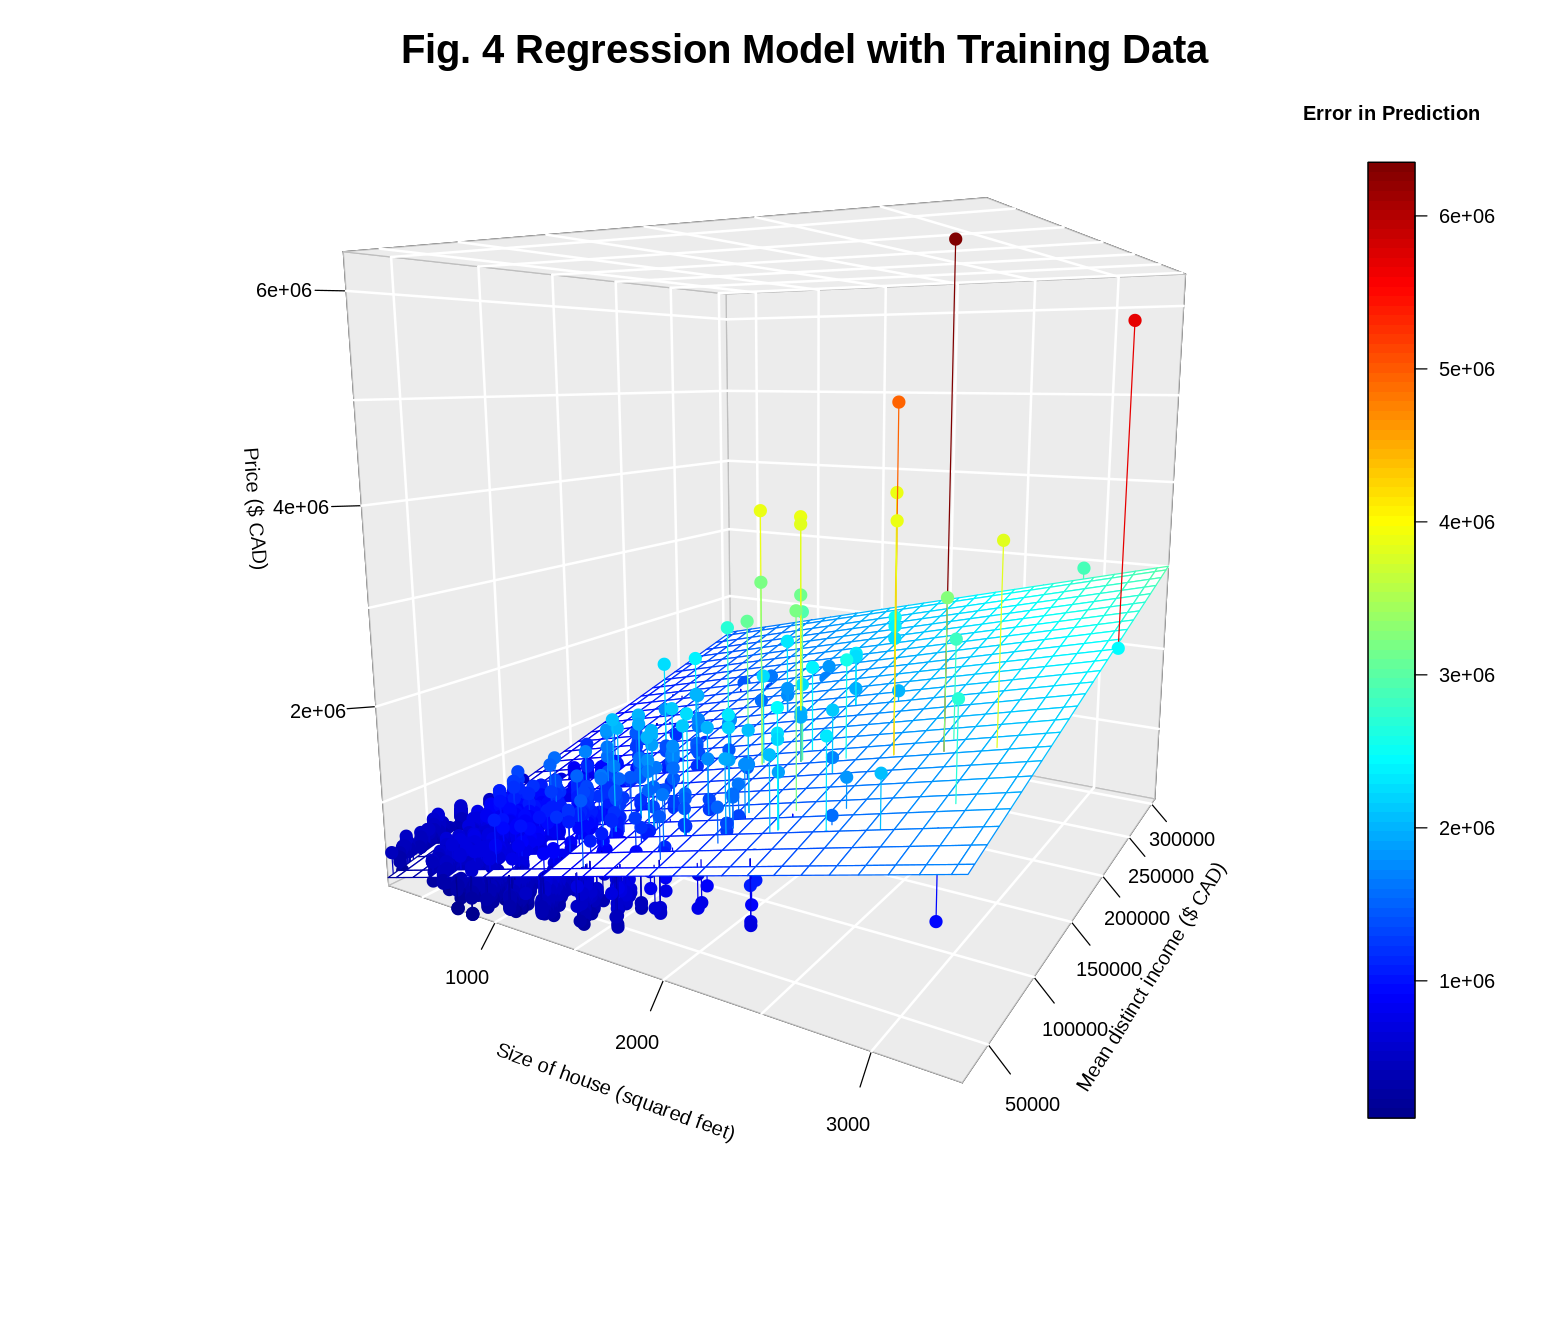

In [13]:
# x, y, z variables
x <- toronto_real_estate_data_training$sqft
y <- toronto_real_estate_data_training$mean_district_income
z <- toronto_real_estate_data_training$price

# Compute the linear regression (z = ax + by + d)
fit <- lm(z ~ x + y)

# predict values on regular xy grid
grid.lines = 26
x.pred <- seq(min(x), max(x), length.out = grid.lines)
y.pred <- seq(min(y), max(y), length.out = grid.lines)
xy <- expand.grid( x = x.pred, y = y.pred)
z.pred <- matrix(predict(fit, newdata = xy), 
                 nrow = grid.lines, ncol = grid.lines)

# fitted points for droplines to surface
fitpoints <- predict(fit)

# Size of Plot
options(repr.plot.width = 13, repr.plot.height = 11)

# scatter plot with regression plane
scatter3D(x, y, z, pch = 20, cex = 2, bty = 'g', # pch = shape of dots (circle),
                                                 # cex = size of dots
                                                 # bty = colour of box (grey)
    theta = 30, phi = 10, ticktype = "detailed", # theta and phi = rotation,
                                                 # ticktype = Adding values
    xlab = "Size of house (squared feet)",
    ylab = "Mean distinct income ($ CAD)",
    zlab = "Price ($ CAD)",
    surf = list(x = x.pred, y = y.pred, z = z.pred, facets = FALSE, fit = fitpoints), # fit = lines between points and plane
    clab = c("Error in Prediction")) # Legend Label
    title(main = list("Fig. 4 Regression Model with Training Data", cex = 2.0)) # Adding title,
                                                                                # cex = changing size of title

Evidently, the error is significantly greater for more expensive condo apartments relative to cheaper ones and that the data is clearly more dense for the cheaper condo apartments.

Perhaps, due to the imbalance in types of observations in the training data, the regression model became biased, and hence, was unable to accurately predict the price of more expensive houses, leading to a higher RMSE.

_Will be explained more in discussion._

## III. Discussion

**3.1. Summarize Findings**

We built a linear regression model to predict the prices of condo apartments in Toronto using two predictors, the size of a house and the mean district income. Our dataset had 7572 total observations, which we split into 75:25 between training and testing data. 
 
Using this training data, we made plots and a linear regression model which allowed us to learn that the two predictors, `sqft` and `mean_district_income` are both positively correlated with `price`. In the regression model, we then used these two predictors to formulate an equation which calculates the value of condo apartments. The model had an RMSE of about 230,000. As explained earlier, considering that the average condo apartment in Toronto costs about $\$630,000$, our model is not excellent, however, it is not terrible either.

**3.2 Discuss whether this is what you expected to find?**

We expected that both `sqft` and `mean_district_income` would have a positive relationship with the `price` of condo apartments. Our hypothesis was correct as our plots show that the linear regression lines both have positive slopes. Therefore, as the size of a condo apartment increases, the price of it should increase too. Similarly, as the mean district income increases, the price should as well.

Although, we did not expect the RMSE to be as high as we calculated. We believed that our data would better fit the model and provide more precise results. 

_The limitations of our analysis which led to the high RMSE will be discussed shortly._

**3.3 Strengths**

First, even though the RMSE of our model was larger than we anticipated, this does not mean that the model will predict the price of all condo apartments poorly. As apartments got more expensive, the error in predictions increased significantly, _see Figure 4_. Thus, it is possible that the model can predict the prices of cheaper apartments more effectively with less error.

Additionally, our linear regression model shows a positive relationship between the predictors and `price`. In reality, it would  make sense that a larger house in a richer neighbourhood would be of greater value. Hence, our model is doing some things right. It is correctly identifying trends between the predictors and price.

Furthermore, considering we only used about 5700 observations for training, we were still able to build a decent model to predict price and fulfilled many of our expectations.

**3.4 Limitations**

First, our dataset may not be a good representation of Toronto houses. We only have 7572 observations, and used approximately 5700 observations to train our model. If we had more data, it could help us make a better linear regression model with a lower RMSE. Moreover, our data could be biased as most of the observations were of a similar price. Thus, this influenced the formula generated by the linear regression model and caused the predictions of the more expensive apartments to be very inaccurate. If our data had more observations, with an even distribution of different costs of apartments, we could have made a better best fit line which could have a lower RMSE.

Additionally, using a linear regression model could have been a limitation. Perhaps, the trend between the predictors, `sqft` and `mean_district_income`, and the `price` of condo apartments is not linear. Maybe, the predictors chosen for the study were not the best to create a linear regression model either. Instead, other variables, such as number of rooms, room sizes, and such, can be used instead and potentially be more accurate. Further, it is possible that different types of regression models, such as KNN, would do a better job at predicting the price of the apartments in the dataset. As seen in the 3D plot, the trend between the predictors and price did not look exactly linear. Using an appropriate K value in KNN's nearest neighbours approach could yield more accurate results.

Moreover, the linear regression model could be improved if a different approach was used. As there are various types of condo apartments, some are worth only a few hundred thousand, whereas others are worth multiple million dollars. Instead of building a general regression model for all apartments in Toronto, the apartments could be clustered into different types, and different linear regression models can be designed for each cluster. This could reduce the RMSE of the models, as the model would not be biased by certain clusters merely due to their abundance, and the best fit line would be closer to all of the points.

**3.5 Discuss what impact could such findings have?**

We found that by using a simple linear regression model, we were able to predict the prices of apartments in Toronto decently. Thus, with a more complex regression model, it is possible for homebuyers and investors to attain reliable estimates of property values based on the apartment’s characteristics. Further, the regression model is cost and time efficient, unlike other algorithms which may not be as interpretable, easy to use, or cheap. Hence, our findings show that such predictive models have potential and can be helpful to those interested in the real estate market.

**3.6 Discuss what future questions could this lead to?**

As discussed in earlier sections, our model does not precisely predict the price of condo apartments in Toronto. Since our dataset does not have a sufficient number of observations with more expensive apartments, for future studies, we can collect more data or balance the data based on price.

Future research can also focus on using other predictors to predict price. It would also be interesting to see how other types of regression models would perform with this data in an extended study.

In Figure 4, we see that a general linear trend is not followed by our data. Perhaps, this is a result of different clusters existing. In future studies, we can investigate whether different linear regression models for each cluster could provide more accurate results.

Further, as we specifically focused on condo apartment prices in Toronto, future studies can investigate whether it is possible to use similar methods to estimate the values of other types of properties in other regions as well.

 ## Citations
 
Foran, P.(2020).COVID-19 pandemic pushes Canadian interest rates to near historic lows.CTV News. https://toronto.ctvnews.ca/covid-19-pandemic-pushes-canadian-interest-rates-to-near-historic-lows-1.4982314

McNutt, Lydia. “Canadian Housing Market Outlook (2021): RE/MAX Canada News.” RE/MAX Canada, 2 Dec. 2020, https://blog.remax.ca/toronto-housing-market-outlook/.

Rane, J. (2020, September 29). Canadian Cities Where It's Cheaper to Buy a Home Today Vs. 5 Years Ago: REPORT. Retrieved November 29, 2020, from https://www.zoocasa.com/blog/canada-cities-homes-cheaper-today-than-5-years-ago/

Slavaspirin. “Slavaspirin/Toronto-Housing-Price-Prediction.” GitHub, https://github.com/slavaspirin/Toronto-housing-price-prediction.